In [1]:
# Necessary imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import argparse

from torch import Tensor

from qiskit import Aer, QuantumCircuit, BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs
from qiskit.aqua.utils.dataset_helper import get_feature_dimension

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from quantic.data import DatasetLoader
    
# Additional torch-related imports
from torch import no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim # Adam, SGD, LBFGS
from torch.nn import NLLLoss # CrossEntropyLoss, MSELoss, L1Loss, BCELoss
from qnetworks import HybridQNN_Shallow
from qnetworks import HybridQNN

#time
import timeit


In [2]:
# network args
n_classes = 2
n_qubits = 2
n_features = None
if n_features is None:
    n_features = n_qubits
network = "resnet18" #hybridqnn_shallow
# train args
batch_size = 4
epochs = 30
LR = 0.001
n_samples_train = 256 #128
n_samples_test = 64 #64
# plot args
n_samples_show = batch_size
# dataset args
shuffle = True
dataset = "CIFAR10" # MNIST / CIFAR10 / CIFAR100, any from pytorch
dataset_cfg = ""
specific_classes_names = ['bird','cat'] # ['0','1'] # selected (filtered) classes
print(specific_classes_names)
use_specific_classes = len(specific_classes_names)>=n_classes
# preprocessing
input_resolution = (32,32) #(28,28) # please check n_filts required on fc1/fc2 to input to qnn
resize_interpolation = transforms.functional.InterpolationMode.BILINEAR 

# Set seed for random generators
rand_seed = np.random.randint(50)
algorithm_globals.random_seed = rand_seed
manual_seed(rand_seed) # Set train shuffle seed (for reproducibility)

if not os.path.exists("plots"):
    os.mkdir("plots")

['bird', 'cat']


In [3]:


######## PREPARE DATASETS
time_start = timeit.timeit()

# Train Dataset
# -------------

if dataset_cfg:
    # Load a dataset configuration file
    dataset = DatasetLoader.load(from_cfg=dataset_cfg,framework='torchvision')
else:
    # Or instantate dataset manually
    dataset = DatasetLoader.load(dataset_type=dataset,
                                   num_classes=n_classes,
                                   specific_classes=specific_classes_names,
                                   num_samples_class_train=n_samples_train,
                                   num_samples_class_test=n_samples_test,
                                   framework='torchvision'
                                   )
print(f'Dataset partitions: {dataset.get_partitions()}')

X_train = dataset['train']
X_test = dataset['test']


# Get channels (rgb or grayscale)
if len(X_train.data.shape)>3: # 3d image (rgb+)
    n_channels = X_train.data.shape[3]
else: # 2d image (grayscale)
    n_channels = 1

# Set preprocessing transforms
list_preprocessing = [
    transforms.Resize(input_resolution),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
X_train.transform= transforms.Compose(list_preprocessing)
X_test.transform = transforms.Compose(list_preprocessing)           

# set filtered/specific class names
classes_str = ",".join(dataset.specific_classes_names)
classes2spec = {}
specific_classes = dataset.specific_classes
for idx, class_idx in enumerate(specific_classes):
    classes2spec[class_idx]=idx

classes_list = dataset.classes
n_samples = n_samples_test

Files already downloaded and verified
Files already downloaded and verified
Dataset partitions: ['train', 'test']


In [4]:
# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=shuffle)
# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=shuffle)

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Dataloaders elapsed time: {time_elapsed} s")

Dataloaders elapsed time: -0.010275285691022873 s


<Figure size 432x288 with 0 Axes>

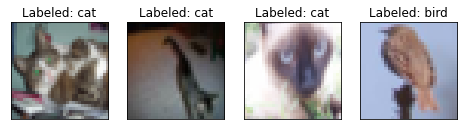

<Figure size 432x288 with 0 Axes>

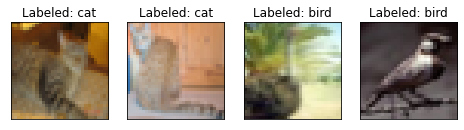

<Figure size 432x288 with 0 Axes>

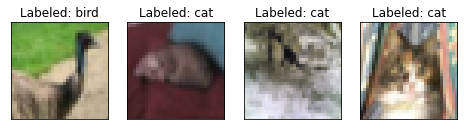

<Figure size 432x288 with 0 Axes>

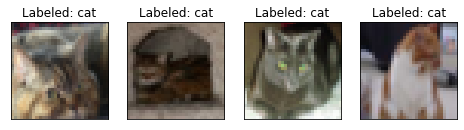

In [5]:
##### VISUALIZE LABELS
data_iter = iter(train_loader)
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    try:
        images, targets = data_iter.__next__()
    except:
        break
    plt.clf()
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for idx, image in enumerate(images):
        axes[idx].imshow(np.moveaxis(images[idx].numpy().squeeze(),0,-1))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        class_label = classes_list[targets[idx].item()]
        axes[idx].set_title("Labeled: {}".format(class_label))
        if idx > n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_labeled_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            break
    plt.show()
    n_samples_show_alt -= 1
    

In [6]:
##### DESIGN NETWORK
time_start = timeit.timeit()



# init network
if network == "hybridqnn_shallow":
    ## predefine number of input filters to fc1 and fc2
    # examples: 13456 for (128x128x1), 59536 for (256x256x1), 256 for (28x28x1), 400 for (28x28x3) or (35x35x1) 
    if n_channels == 1:
        n_filts_fc1 = int(((((input_resolution[0]-4)/2)-4)/2)**2)*16
    else:
        n_filts_fc1 = int(((((input_resolution[0]+7-4)/2)-4)/2)**2)*16
    n_filts_fc2 = int(n_filts_fc1 / 4)

    # declare quantum instance
    qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
    # Define QNN
    feature_map = ZZFeatureMap(n_features)
    ansatz = RealAmplitudes(n_qubits, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        n_qubits, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
    )
    print(qnn.operator)
    qnn.circuit.draw(output="mpl",filename=f"plots/qnn{n_qubits}_{n_classes}classes.png")
    #from qiskit.quantum_info import Statevector
    #from qiskit.visualization import plot_bloch_multivector
    #state = Statevector.from_instruction(qnn.circuit)
    #plot_bloch_multivector(state)
    model = HybridQNN_Shallow(n_classes = n_classes, n_qubits = n_qubits, n_channels = n_channels, n_filts_fc1 = n_filts_fc1, n_filts_fc2 = n_filts_fc2, qnn = qnn)
    print(model)

    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_func = NLLLoss()

elif network == "QSVM":
    backend = BasicAer.get_backend('qasm_simulator')

    # todo: fix this transformation for QSVM
    train_input = X_train.targets
    test_input = X_test.targets
    total_array = np.concatenate([test_input[k] for k in test_input])
    #
    feature_map = ZZFeatureMap(feature_dimension=get_feature_dimension(train_input),
                               reps=2, entanglement='linear')
    svm = QSVM(feature_map, train_input, test_input, total_array,
               multiclass_extension=AllPairs())
    quantum_instance = QuantumInstance(backend, shots=1024,
                                       seed_simulator=algorithm_globals.random_seed,
                                       seed_transpiler=algorithm_globals.random_seed)
else:
    model = HybridQNN(backbone=network,pretrained=True,n_qubits=n_qubits,n_classes=n_classes)
    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.network.parameters(), lr=LR)
    loss_func = NLLLoss()
    
time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Network init elapsed time: {time_elapsed} s")

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

In [ ]:
################# TRAIN
# Start training
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.train()  # Set model to training mode
    if network == "hybridqnn_shallow":
        model.train()  # Set model to training mode
        
    loss_list = []  # Store loss history
    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = model(data)  # Forward pass

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            loss = loss_func(output, target)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss.append(loss.item())  # Store loss
            print(f"Batch {batch_idx}, Loss: {total_loss[-1]}")
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

    # Plot loss convergence
    plt.clf()
    plt.plot(loss_list)
    plt.title("Hybrid NN Training Convergence")
    plt.xlabel("Training Iterations")
    plt.ylabel("Neg. Log Likelihood Loss")
    #plt.savefig(f"plots/{dataset}_classification{classes_str}_hybridqnn_q{n_qubits}_{n_samples}samples_lr{LR}_bsize{batch_size}.png")
    plt.show()
    
elif network == "QSVM":
    result = svm.run(quantum_instance)
    for k,v in result.items():
        print(f'{k} : {v}')

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Training time: {time_elapsed} s")

Batch 0, Loss: -0.5367425680160522
Batch 1, Loss: -0.08628901094198227
Batch 2, Loss: -0.3303743004798889
Batch 3, Loss: -0.7142787575721741
Batch 4, Loss: -0.7725785970687866
Batch 5, Loss: -0.6224437952041626
Batch 6, Loss: -0.17242267727851868
Batch 7, Loss: -0.3345692455768585
Batch 8, Loss: -0.41406965255737305
Batch 9, Loss: -0.19218885898590088
Batch 10, Loss: -0.6523440480232239
Batch 11, Loss: -0.8397375345230103
Batch 12, Loss: -0.8487256169319153
Batch 13, Loss: -0.9014620184898376
Batch 14, Loss: -0.4306139647960663
Batch 15, Loss: -0.5582020878791809
Batch 16, Loss: -0.27227336168289185
Batch 17, Loss: -0.27675101161003113
Batch 18, Loss: -0.11890754103660583
Batch 19, Loss: -0.5474928617477417
Batch 20, Loss: -0.6713637709617615
Batch 21, Loss: -0.6122459173202515
Batch 22, Loss: -0.4355641007423401
Batch 23, Loss: -0.4763459861278534
Batch 24, Loss: -0.7609845399856567
Batch 25, Loss: -0.3923785388469696
Batch 26, Loss: -0.2950136661529541
Batch 27, Loss: -0.618605554103

Batch 114, Loss: -0.4810832738876343
Batch 115, Loss: -0.7874804139137268
Batch 116, Loss: -0.3929501473903656
Batch 117, Loss: -0.5634334683418274
Batch 118, Loss: -0.4498893916606903
Batch 119, Loss: -0.6479448676109314
Batch 120, Loss: -0.3631463944911957
Batch 121, Loss: -0.7000526189804077
Batch 122, Loss: -0.5548267364501953
Batch 123, Loss: -0.2733334004878998
Batch 124, Loss: -0.8890880942344666
Batch 125, Loss: -0.40779101848602295
Batch 126, Loss: -0.5308926105499268
Batch 127, Loss: -0.37882760167121887
Training [7%]	Loss: -0.4900
Batch 0, Loss: -0.3113418519496918
Batch 1, Loss: -0.39318299293518066
Batch 2, Loss: -0.42088717222213745
Batch 3, Loss: -0.6813923120498657
Batch 4, Loss: -0.8719532489776611
Batch 5, Loss: -0.685313880443573
Batch 6, Loss: -0.787820041179657
Batch 7, Loss: -0.14601492881774902
Batch 8, Loss: -0.2081756889820099
Batch 9, Loss: -0.36110058426856995
Batch 10, Loss: -0.34871330857276917
Batch 11, Loss: -0.6761146783828735
Batch 12, Loss: -0.59943556

Batch 83, Loss: -0.27659761905670166
Batch 84, Loss: -0.6498438119888306
Batch 85, Loss: -0.5747909545898438
Batch 86, Loss: -0.550532341003418
Batch 87, Loss: -0.6319975852966309
Batch 88, Loss: -0.6527642011642456
Batch 89, Loss: -0.8540850877761841
Batch 90, Loss: -0.19158953428268433
Batch 91, Loss: -0.44632476568222046
Batch 92, Loss: -0.4493134319782257
Batch 93, Loss: -0.611121654510498
Batch 94, Loss: -0.516426682472229
Batch 95, Loss: -0.5523818135261536
Batch 96, Loss: -0.48936334252357483
Batch 97, Loss: -0.5915182828903198
Batch 98, Loss: -0.569390594959259
Batch 99, Loss: -0.4840870499610901
Batch 100, Loss: -0.5118936896324158
Batch 101, Loss: -0.6191831827163696
Batch 102, Loss: -0.585117518901825
Batch 103, Loss: -0.6314388513565063
Batch 104, Loss: -0.736251950263977
Batch 105, Loss: -0.4308798909187317
Batch 106, Loss: -0.7496780157089233
Batch 107, Loss: -0.7749837040901184
Batch 108, Loss: -0.6710548400878906
Batch 109, Loss: -0.4421841502189636
Batch 110, Loss: -0.

Batch 51, Loss: -0.32248905301094055
Batch 52, Loss: -0.4978654682636261
Batch 53, Loss: -0.12431921064853668
Batch 54, Loss: -0.5132637023925781
Batch 55, Loss: -0.19209347665309906
Batch 56, Loss: -0.46593576669692993
Batch 57, Loss: -0.6258986592292786
Batch 58, Loss: -0.3921496272087097
Batch 59, Loss: -0.4992173910140991
Batch 60, Loss: -0.618631899356842
Batch 61, Loss: -0.5626033544540405
Batch 62, Loss: -0.579034149646759
Batch 63, Loss: -0.6555068492889404
Batch 64, Loss: -0.4333499073982239
Batch 65, Loss: -0.41158896684646606
Batch 66, Loss: -0.5067563056945801
Batch 67, Loss: -0.6338312029838562
Batch 68, Loss: -0.44914957880973816
Batch 69, Loss: -0.6254193782806396
Batch 70, Loss: -0.6612566709518433
Batch 71, Loss: -0.316627562046051
Batch 72, Loss: -0.30281704664230347
Batch 73, Loss: -0.7224801182746887
Batch 74, Loss: -0.3508599102497101
Batch 75, Loss: -0.44673046469688416
Batch 76, Loss: -0.48902004957199097
Batch 77, Loss: -0.821433424949646
Batch 78, Loss: -0.3266

Batch 19, Loss: -0.37870585918426514
Batch 20, Loss: -0.6863508224487305
Batch 21, Loss: -0.6953842639923096
Batch 22, Loss: -0.303565114736557
Batch 23, Loss: -0.6925516128540039
Batch 24, Loss: -0.39972418546676636
Batch 25, Loss: -0.5979310870170593
Batch 26, Loss: -0.6236593723297119
Batch 27, Loss: -0.679890513420105
Batch 28, Loss: -0.6097424030303955
Batch 29, Loss: -0.6366922855377197
Batch 30, Loss: -0.6343220472335815
Batch 31, Loss: -0.4294199049472809
Batch 32, Loss: -0.283001184463501
Batch 33, Loss: -0.4215238094329834
Batch 34, Loss: -0.7880620956420898
Batch 35, Loss: -0.5008576512336731
Batch 36, Loss: -0.4911201298236847
Batch 37, Loss: -0.5300731658935547
Batch 38, Loss: -0.5667683482170105
Batch 39, Loss: -0.3275012969970703
Batch 40, Loss: -0.3945541977882385
Batch 41, Loss: -0.20262043178081512
Batch 42, Loss: -0.3913435935974121
Batch 43, Loss: -0.6715695261955261
Batch 44, Loss: -0.709016740322113
Batch 45, Loss: -0.5782938003540039
Batch 46, Loss: -0.2406410872

Batch 116, Loss: -0.6531456708908081
Batch 117, Loss: -0.04576978087425232
Batch 118, Loss: -0.44945526123046875
Batch 119, Loss: -0.5907325148582458
Batch 120, Loss: -0.48508408665657043
Batch 121, Loss: -0.3832949697971344
Batch 122, Loss: -0.3383122682571411
Batch 123, Loss: -0.5437734723091125
Batch 124, Loss: -0.39470329880714417
Batch 125, Loss: -0.3757585287094116
Batch 126, Loss: -0.1266230046749115
Batch 127, Loss: -0.7276859283447266
Training [30%]	Loss: -0.4999
Batch 0, Loss: -0.5416167974472046
Batch 1, Loss: -0.7703795433044434
Batch 2, Loss: -0.5338261723518372
Batch 3, Loss: 0.05099605396389961
Batch 4, Loss: -0.644387423992157
Batch 5, Loss: -0.4053493142127991
Batch 6, Loss: -0.5177704095840454
Batch 7, Loss: -0.5138243436813354
Batch 8, Loss: -0.5798583030700684
Batch 9, Loss: -0.4285902976989746
Batch 10, Loss: -0.1858387440443039
Batch 11, Loss: -0.7256419658660889
Batch 12, Loss: -0.5875396728515625
Batch 13, Loss: -0.29876643419265747
Batch 14, Loss: -0.4384928941

In [ ]:
######## TEST
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.eval()  # Set model to eval mode
    if network == "hybridqnn_shallow":
        model.eval()  # Set model to eval mode
    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)
            pred = output.argmax(dim=1, keepdim=True)

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
            )
        )

    time_end = timeit.timeit()
    time_elapsed = time_end - time_start
    print(f"Test time: {time_elapsed} s")
    
    


In [ ]:
# Plot predicted labels
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    plt.clf()
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for batch_idx, (data, target) in enumerate(test_loader):    
        if count == n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_pred_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            plt.show()
            break
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        for sample_idx in range(batch_size):
            try:
                class_label = classes_list[specific_classes[pred[sample_idx].item()]]
            except:
                class_label = classes_list[specific_classes[pred[sample_idx].item()-1]]
            axes[count].imshow(np.moveaxis(data[sample_idx].numpy().squeeze(),0,-1))
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title(class_label)
            count += 1
    n_samples_show_alt -= 1

### 